In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use("ggplot")

pd.set_option('display.max_columns', None)

Missing colon in file '/Users/christianelorenz/.matplotlib/matplotlibrc', line 1 ('cat ~/.matplotlib/matplotlibrc')


Read in the full dataset:

In [3]:
df=pd.read_csv("../../trainset_full.csv", low_memory=False)

Define new feature "Error" that indicates if there is any error. This is the target variable which we would like to predict. Define which features are used.

In [4]:
df["Error"]=df.error_category != "NO_ERROR"
X_train=df[['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id']]
y_train=df.Error
y_train_full=df.error_category

In [48]:
import datetime as dt
X_train["measured_at"]=pd.to_datetime(X_train.measured_at) 
X_train["month"]=X_train.measured_at.dt.month
X_train["bimonth"]=X_train.month // 2 
X_train["bimonthpark"]= str(X_train.bimonth)+":"+str(X_train.park_id)
X_train["Error"]=df.Error

df["measured_at"]=pd.to_datetime(df.measured_at) 
df["month"]=df.measured_at.dt.month
df["bimonth"]=df.month// 2 
df["bimonthpark"]= str(X_train.bimonth)+":"+str(X_train.park_id)

In [6]:
X_train.columns

Index(['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'month', 'bimonth',
       'bimonthpark', 'Error'],
      dtype='object')

In the data exploration we have seen that the features rotor_speed and generator_speed are highly correlated with each other, as well as nacelle_direction and wind_direction. Therefore we can merge these four features into two features. 

In [57]:
X_train["speed"]=(X_train.rotor_speed+X_train.generator_speed)/2
X_train["direction"]=(X_train.nacelle_direction+X_train.wind_direction)/2

df["speed"]=(df.rotor_speed+df.generator_speed)/2
df["direction"]=(df.nacelle_direction+df.wind_direction)/2
df["hourofday"]=df.measured_at.dt.hour
df["isnight"]=(df.hourofday >= 18) | (df.hourofday <=5)

In [58]:
num_attribs=['speed', 'power',
       'direction', 'rotor_speed', 'generator_speed','wind_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure']
cat_attribs=['park_id','bimonthpark','bimonth','turbine_id','isnight']

In [ ]:
Next, we split the dataset into 

In [59]:
print(df.measured_at.min())
print(df.measured_at.max())
print(df.measured_at.max()-df.measured_at.min())

2019-01-01 00:00:00+00:00
2021-04-30 22:50:00+00:00
850 days 22:50:00


In [60]:
pd.to_datetime("2020-04-30")

Timestamp('2020-04-30 00:00:00')

In [61]:
df_train=df[df.measured_at < pd.Timestamp("2020-04-29", tz="Europe/Brussels")]
df_test=df[df.measured_at >=pd.Timestamp("2020-04-29", tz="Europe/Brussels") ]

In [13]:
df_train.shape

(692184, 25)

In [14]:
df_test.shape

(675006, 25)

In [15]:
df.dtypes
df.bimonthpark=str(df.bimonthpark)
df.dtypes

index                               int64
turbine_id                          int64
measured_at           datetime64[ns, UTC]
wind_speed                        float64
power                             float64
nacelle_direction                 float64
wind_direction                    float64
rotor_speed                       float64
generator_speed                   float64
temp_environment                    int64
temp_hydraulic_oil                  int64
temp_gear_bearing                   int64
cosphi                            float64
blade_angle_avg                   float64
hydraulic_pressure                float64
park_id                             int64
error_category                     object
Error                                bool
month                               int64
bimonth                             int64
bimonthpark                        object
speed                             float64
direction                         float64
hourofday                         

In [16]:
X_train=df_train.copy()
X_test=df_test.copy()
y_train=df_train.Error.copy()
y_test=df_test.Error.copy()
X_train.dtypes

index                               int64
turbine_id                          int64
measured_at           datetime64[ns, UTC]
wind_speed                        float64
power                             float64
nacelle_direction                 float64
wind_direction                    float64
rotor_speed                       float64
generator_speed                   float64
temp_environment                    int64
temp_hydraulic_oil                  int64
temp_gear_bearing                   int64
cosphi                            float64
blade_angle_avg                   float64
hydraulic_pressure                float64
park_id                             int64
error_category                     object
Error                                bool
month                               int64
bimonth                             int64
bimonthpark                        object
speed                             float64
direction                         float64
hourofday                         

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(sparse=False, drop="first")
encoder.fit(X_train[cat_attribs])
encoded_cols=list(encoder.get_feature_names_out(cat_attribs))
X_train[encoded_cols]=encoder.transform(X_train[cat_attribs])
X_test[encoded_cols]=encoder.transform(X_test[cat_attribs])

In [18]:
X_train[num_attribs].dtypes

speed                 float64
power                 float64
direction             float64
rotor_speed           float64
generator_speed       float64
wind_speed            float64
temp_environment        int64
temp_hydraulic_oil      int64
temp_gear_bearing       int64
cosphi                float64
blade_angle_avg       float64
hydraulic_pressure    float64
dtype: object

In [19]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train[num_attribs])
X_train[num_attribs]=scaler.transform(X_train[num_attribs])
X_test[num_attribs]=scaler.transform(X_test[num_attribs])

In [20]:
#train a lasso and/or elastic model with logistic regression, using CV 

#the cv in glum for binomial is done (presumably) via deviance and not accuracy, but small deviance => good accuracy in principle
from glum import GeneralizedLinearRegressorCV

lin_reg=GeneralizedLinearRegressorCV(family="binomial", link="logit", cv=5, 
                                     min_alpha=0.0001, l1_ratio=[0.8, 0.9,1], 
                                     fit_intercept=True,
                                     max_iter=150)

lin_reg.fit(X_train[num_attribs+encoded_cols],y_train)

/Users/christianelorenz/Documents/Career development/env3/lib/python3.9/site-packages/glum/_link.py:259: UserWarning: Computing sigmoid function gave results too close to 0 or 1. Clipping.
  warnings.warn(


GeneralizedLinearRegressorCV(cv=5, family='binomial', l1_ratio=[0.8, 0.9, 1],
                             link='logit', max_iter=150, min_alpha=0.0001)

In [21]:
print("alpha:", lin_reg.alpha_ ,", l1_ratio:", lin_reg.l1_ratio_)

alpha: 0.002069948461195029 , l1_ratio: 0.8


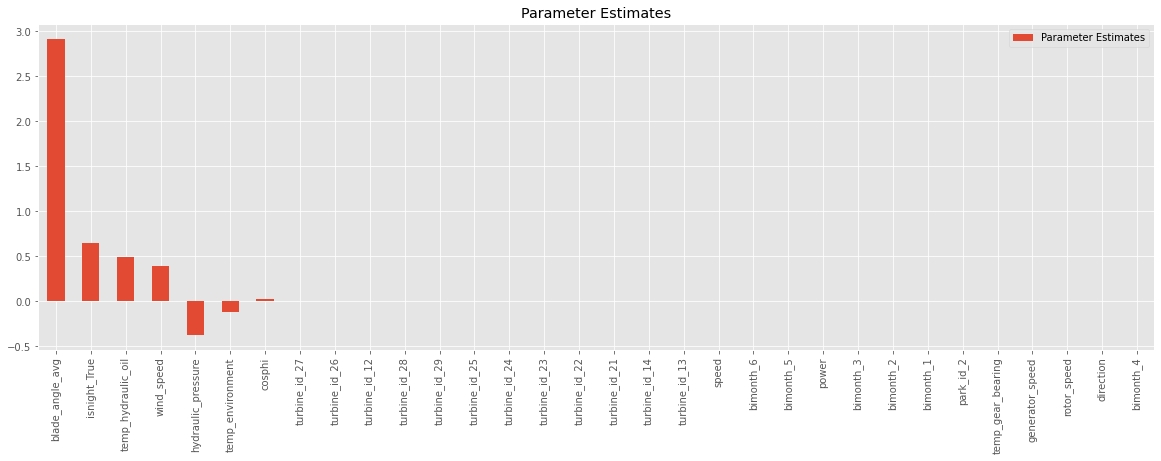

In [22]:
#plot the largest coefficients
coefs=pd.DataFrame(lin_reg.coef_, index=X_test[num_attribs+encoded_cols].columns,columns=["Parameter Estimates"])
coefs.sort_values(by="Parameter Estimates",key=abs,ascending=False).plot(kind="bar",figsize=(20,6));
plt.title("Parameter Estimates");

In [23]:
#Baseline accuracy by always guessing no error:
print("The Baseline error is:",round(np.sum(y_test)/len(y_test)*100,2), "%")

The Baseline error is: 7.2 %


In [24]:
y_hat_test=(lin_reg.predict(X_test[num_attribs+encoded_cols])>=0.5)
from sklearn.metrics import accuracy_score
print("Accuracy is", round(accuracy_score(y_hat_test,y_test)*100,2), "%", )

Accuracy is 98.81 %


In [25]:
y_baseline=np.zeros(len(y_test))

from sklearn.metrics import f1_score

print("F1 score of baseline is", f1_score(y_test,y_baseline))
print("F1 score of glm lasso is", f1_score(y_test,y_hat_test))

F1 score of baseline is 0.0
F1 score of glm lasso is 0.9120972083365377


In [26]:
#now fit xgboost
df_train.columns

Index(['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'error_category',
       'Error', 'month', 'bimonth', 'bimonthpark', 'speed', 'direction',
       'hourofday', 'isnight'],
      dtype='object')

In [27]:
xgb_attribs=['turbine_id', 'wind_speed', 'power',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'month', 'speed', 'direction', 'hourofday']

X_train_xgb=df_train[xgb_attribs]
X_test_xgb=df_test[xgb_attribs]

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb=XGBClassifier(eval_metric="logloss",use_label_encoder=False)
parameters={"n_estimators":[100], "learning_rate":[0.1], "max_depth":[6]}
#parameters2={"n_estimators":[75,85,100], "learning_rate":[0.1], "max_depth":[6],"min_child_weight":[1]}

xgb_cv=GridSearchCV(xgb, parameters2, scoring="accuracy",cv=5)
xgb_cv.fit(X_train_xgb,y_train)

print("Best parameters:", xgb_cv.best_params_ , ", Best CV Accuracy:", xgb_cv.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 75} , Best CV Accuracy: 0.7847323094588254


In [52]:
y_hat_xgb=xgb_cv.best_estimator_.predict(X_test_xgb)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat_xgb,y_test)),2), "%")

XGBC has test accuracy 99.44 %


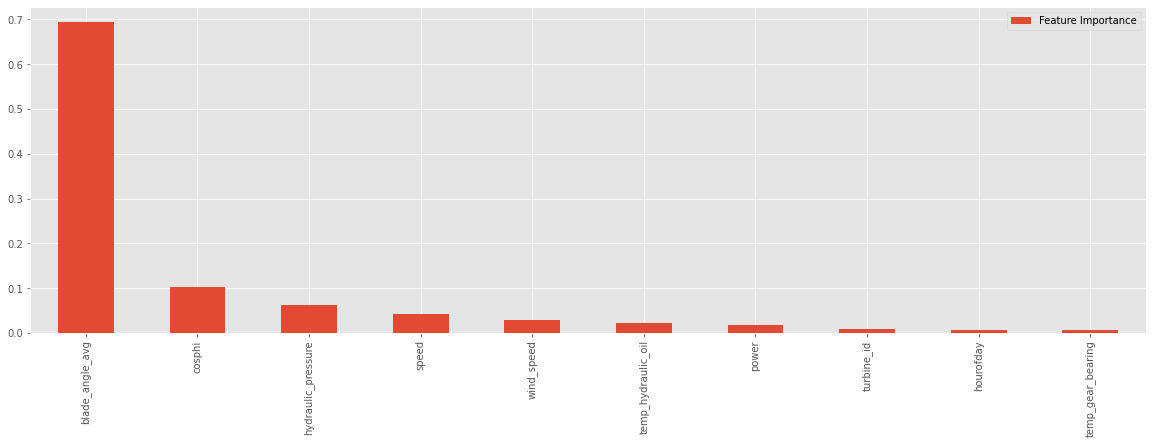

In [53]:
#plot feature importance of xgb
importance_df=pd.DataFrame(xgb_cv.best_estimator_.feature_importances_,index=X_train_xgb.columns, columns=["Feature Importance"])
importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [55]:
print("F1 score of baseline is", f1_score(y_test,y_baseline))
print("F1 score of XGBC is", f1_score(y_test,y_hat_xgb))

F1 score of baseline is 0.0
F1 score of XGBC is 0.960971699858191
